In [13]:
import pandas as pd
import numpy as np
import statistics
from collections import defaultdict
from dash import html, dcc, callback, Output, Input
from pm4py.objects.log.util import interval_lifecycle
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.util import dataframe_utils
from pm4py.algo.simulation.montecarlo import algorithm as montecarlo_simulation
from pm4py.algo.conformance.tokenreplay.algorithm import Variants
import plotly.graph_objects as go
import pm4py
import dash
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, poisson, expon, gamma, weibull_min, kstest
from scipy.integrate import quad
import matplotlib.pyplot as plt
import BPSimpy


In [14]:
file_name = "sim.bpmn"

log = pm4py.read_xes("running-example.xes")
#log2 = pm4py.read_xes("BPI_Challenge_2012.xes")


net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(log)
bpmn = pm4py.convert_to_bpmn(net, initial_marking, final_marking)

pm4py.write_bpmn(bpmn, file_name)
example = BPSimpy.BPSim(file_name,verbosity=None)

parsing log, completed traces ::   0%|          | 0/6 [00:00<?, ?it/s]

c:\Users\Yannic\anaconda3\envs\masterarbeit\Lib\site-packages\pm4py\objects\log\util\dataframe_utils.py:176: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

c:\Users\Yannic\anaconda3\envs\masterarbeit\Lib\site-packages\pm4py\objects\log\util\dataframe_utils.py:176: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

c:\Users\Yannic\anaconda3\envs\masterarbeit\Lib\site-packages\pm4py\objects\log\util\dataframe_utils.py:176: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



In [25]:
ACTIVITY = "concept:name"
TRACE = "case:concept:name"
TIMESTAMP = "time:timestamp"
END  = "time:timestamp"
START = "start_timestamp"
WAITING = "waiting_times"
DURATION = "duration"

# import log
log = xes_importer.apply('BPI_Challenge_2012.xes', variant=xes_importer.Variants.LINE_BY_LINE)
#log = xes_importer.apply('example.xes', variant=xes_importer.Variants.LINE_BY_LINE)
log = log_converter.apply(log, variant=log_converter.Variants.TO_DATA_FRAME)
log = dataframe_utils.convert_timestamp_columns_in_df(log, timest_format=pd.Timestamp.isoformat)

# convert to interval style log
log = pm4py.convert_to_dataframe(interval_lifecycle.to_interval(pm4py.convert_to_event_log(log)))

# filter top k
log = pm4py.filter_variants_top_k(log, 2)

# Make the log interval style
log = pm4py.convert_to_dataframe(interval_lifecycle.to_interval(pm4py.convert_to_event_log(log)))



c:\Users\Yannic\anaconda3\envs\masterarbeit\Lib\site-packages\pm4py\utils.py:495: UserWarning:

the EventLog class has been deprecated and will be removed in a future release.

c:\Users\Yannic\anaconda3\envs\masterarbeit\Lib\site-packages\pm4py\utils.py:495: UserWarning:

the EventLog class has been deprecated and will be removed in a future release.



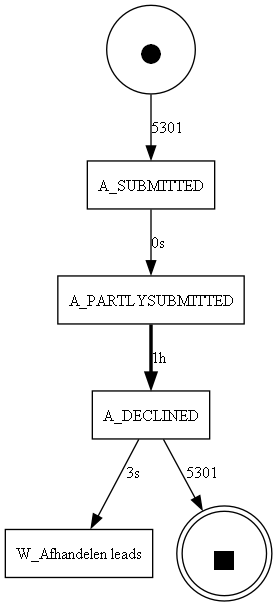

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\Yannic\anaconda3\envs\masterarbeit\Lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning:

Mean of empty slice.

c:\Users\Yannic\anaconda3\envs\masterarbeit\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning:

invalid value encountered in scalar divide

Exception in thread Thread-335:
Traceback (most recent call last):
  File "c:\Users\Yannic\anaconda3\envs\masterarbeit\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "c:\Users\Yannic\anaconda3\envs\masterarbeit\Lib\site-packages\pm4py\algo\simulation\montecarlo\variants\petri_semaph_fifo.py", line 191, in run
    ct = stochastic_utils.pick_transition(et, smap)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Yannic\anaconda3\envs\masterarbeit\Lib\site-packages\pm4py\objects\stochastic_petri\utils.py", line 47, in pick_transition
    ct = list(choice(et, 1, p=probability_distribution))[0]
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "mtrand.pyx",

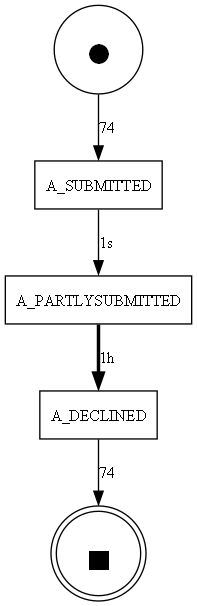

In [26]:
dfg, sa, ea = pm4py.discover_performance_dfg(log)
net, im, fm = pm4py.convert_to_petri_net(dfg, sa, ea)
pm4py.view_performance_dfg(dfg, sa, ea)


parameters = {    
    montecarlo_simulation.Variants.PETRI_SEMAPH_FIFO.value.Parameters.PARAM_CASE_ARRIVAL_RATIO : 20000,
    montecarlo_simulation.Variants.PETRI_SEMAPH_FIFO.value.Parameters.PARAM_ENABLE_DIAGNOSTICS : False,
    montecarlo_simulation.Variants.PETRI_SEMAPH_FIFO.value.Parameters.PARAM_FORCE_DISTRIBUTION: 'EXPONENTIAL'
}


simulated_log, res = montecarlo_simulation.apply(log, net, im, fm, parameters=parameters)
simulated_dfg, sa, ea = pm4py.discover_performance_dfg(simulated_log)


pm4py.view_performance_dfg(simulated_dfg, sa, ea)

for idx, trace in enumerate(simulated_log):
    for event in trace:
        event[TRACE] = int(idx)

# Make the simulated log interval style
simulated_log = pm4py.convert_to_dataframe(interval_lifecycle.to_interval(pm4py.convert_to_event_log(simulated_log)))

In [27]:
def get_trace_durations_in_s(event_log):
    durations = {}
    for case, group in event_log.groupby(TRACE):
        durations[case] = int((group[TIMESTAMP].max() - group[TIMESTAMP].min()).total_seconds())

    # Print the result
    return durations

def parse_event_log(event_log):
    # Initialize a dictionary to store node and link data
    activities = defaultdict(lambda: {DURATION: []})
    transitions = defaultdict(lambda: {WAITING: [], "total_frequency": 0})

    previous_event = None
    for _, current_event in event_log.iterrows():

        current_activity = current_event[ACTIVITY]
        duration = 0

        '''
        The next block currently wrongly calculates waiting times. 
        TODO: Calculate Waiting times based on estimated startup timestamps
        '''
        if previous_event is not None and previous_event[TRACE] == current_event[TRACE]:
            transition = (previous_event[ACTIVITY], current_activity)
            # event duration, assuming the absence of start timestamps
            duration = (current_event[END] - previous_event[END]).total_seconds() 
            # deprecated waiting time calculation
            waiting_time = (current_event[START] - previous_event[END]).total_seconds()

            transitions[transition]["total_frequency"] += 1
            transitions[transition][WAITING].append(waiting_time)
            
        activities[current_activity][DURATION].append(duration)

        previous_event = current_event

    for transition, metrics in transitions.items():
        waiting_times= transitions[transition][WAITING]

        transitions[transition]['sum'] = sum(waiting_times)
        transitions[transition]['min'] = min(waiting_times)
        transitions[transition]['max'] = max(waiting_times)
        transitions[transition]['median'] = statistics.median(waiting_times)
        transitions[transition]['mean'] = statistics.mean(waiting_times)
        transitions[transition]['stdev'] = statistics.stdev(waiting_times) if len(waiting_times) > 1 else 0

    epsilon = 1e-9

    mean_values = [round(value['mean']) + epsilon for value in transitions.values()]
    median_values = [round(value['median']) + epsilon for value in transitions.values()]
    max_values = [round(value['max']) + epsilon for value in transitions.values()]
    min_values = [round(value['min']) + epsilon for value in transitions.values()]
    sum_values = [round(value['sum']) + epsilon for value in transitions.values()]
    stdev_values = [round(value['stdev']) + epsilon for value in transitions.values()]

    metrics = {"mean": mean_values, "median": median_values, "max":max_values, "min": min_values, "sum": sum_values, "stdev" : stdev_values}

    trace_durations = get_trace_durations_in_s(event_log)
    trace_count = len(event_log.groupby(TRACE).size())

    return dict(activities), dict(transitions), metrics, trace_durations, trace_count


In [28]:
'''
get the best fitting Distribution by using the Kolmogorov-Smirnov Test 
'''
def get_best_fit_distribution_via_ks_statistic(data, x_values):
    # Initialize variables to store KS statistics
    ks_statistics = []

    mean_data = np.mean(data)
    # Define the distributions to test
    if mean_data == 0:
        distributions = [norm(0, 1),  # Default to standard normal distribution if mean is 0
                        poisson(1),
                        expon(scale=1.0),  # Default scale if mean is 0
                        gamma(2, scale=1.0),
                        weibull_min(2, scale=1.0)]
    else:
        distributions = [norm(mean_data, np.std(data)),
                        poisson(mean_data),
                        expon(scale=1/mean_data),  # Handle mean_data == 0
                        gamma(2, scale=mean_data/2),
                        weibull_min(2, scale=mean_data/1.64)]

    # Distribution names for labeling
    dist_names = ['Normal', 'Poisson',
                'Exponential', 'Gamma',
                'Weibull']

    # Perform KS test for each distribution and store the KS statistic
    for i, dist in enumerate(distributions):
        ks_statistic, _ = kstest(data, dist.cdf)
        ks_statistics.append(ks_statistic)

    # Find the index of the best-fitting distribution (smallest KS statistic)
    best_fit_index = np.argmin(ks_statistics)
    best_fit_distribution = distributions[best_fit_index]

    # Calculate the best-fitting PDFs for the data set
    best_fit = best_fit_distribution.pdf(x_values)

    return best_fit, dist_names[best_fit_index]


'''
Takes two arrays of data
returns the difference between the integrals of the best fitting probability distribution function for each arary
'''
def get_pdf_integral_difference(log_data, sim_data, title_label='', plot=False):

    # Calculate the number of bins based on the combined data
    combined_data = np.concatenate([log_data, sim_data])
    num_bins = len(np.unique(combined_data))

    # Estimate PDFs for each data set
    x_values = np.linspace(min(combined_data), max(combined_data), 1000)

    best_fit_log_data, best_fit_log_data_name = get_best_fit_distribution_via_ks_statistic(log_data, x_values)
    best_fit_sim_data, best_fit_sim_data_name = get_best_fit_distribution_via_ks_statistic(sim_data, x_values)


    # Calculate the integral distance between the best-fitting PDFs if its NaN set the value to 0
    integral_distance = np.abs(np.trapz(best_fit_log_data - best_fit_sim_data, x_values))
    integral_distance = 0 if np.isnan(integral_distance) else integral_distance

    if not plot : return integral_distance

    # Plot histograms for both data sets
    plt.hist([log_data, sim_data], bins=num_bins, label=['Log Data', 'Sim Data'], density=True, alpha=0.7)

    # Plot the best-fitting PDF for Log Data
    plt.plot(x_values, best_fit_log_data, label=f'Best-Fitting PDF ({best_fit_log_data_name}) for Log Data', color='blue')

    # Plot the best-fitting PDF for Sim Data
    plt.plot(x_values, best_fit_sim_data, label=f'Best-Fitting PDF ({best_fit_sim_data_name}) for Sim Data', color='orange')

    # Add labels, title, and legend
    plt.xlabel('Value')
    plt.ylabel('PDF')
    plt.title(f'Probability Density Functions {title_label}')
    plt.annotate(f'Integral Distance: {integral_distance}', xy=(0.5, -0.25), xycoords='axes fraction', ha='center')
    plt.legend()

    # Show the plot
    plt.show()

    return integral_distance

def get_logs_distance(log, sim_log, alpha=1):
    activities, _, _, trace_durations, _ = parse_event_log(log)
    sim_activities, _, _, sim_trace_durations, _ = parse_event_log(sim_log)

    og_traces = list(trace_durations.values())
    sim_traces = [value * alpha for value in sim_trace_durations.values()]
    trace_difference = get_pdf_integral_difference(og_traces,sim_traces)

    
    activity_differences = [
        get_pdf_integral_difference(
            activities[k][DURATION],
            [duration * alpha for duration in sim_activities[k][DURATION]]
        )
        for k in activities.keys()
    ]

    return trace_difference + sum(activity_differences)


In [29]:
def find_alpha(data, sim_data, granularity):
    alpha = best_alpha = 0 + granularity
    diff = best_diff = get_pdf_integral_difference(data, sim_data)

    while alpha <= 1:
        sim_data = [alpha * date for date in sim_data]


In [30]:
activities, transitions, metrics, trace_durations, trace_count = parse_event_log(log)
sim_nodes, sim_links, sim_metrics, sim_trace_durations, sim_trace_count = parse_event_log(simulated_log)

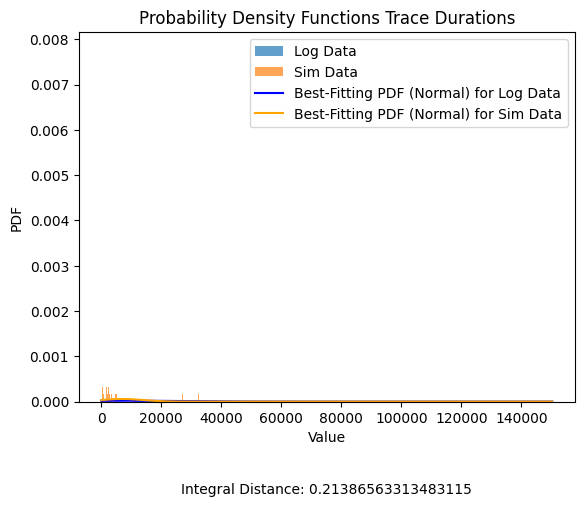

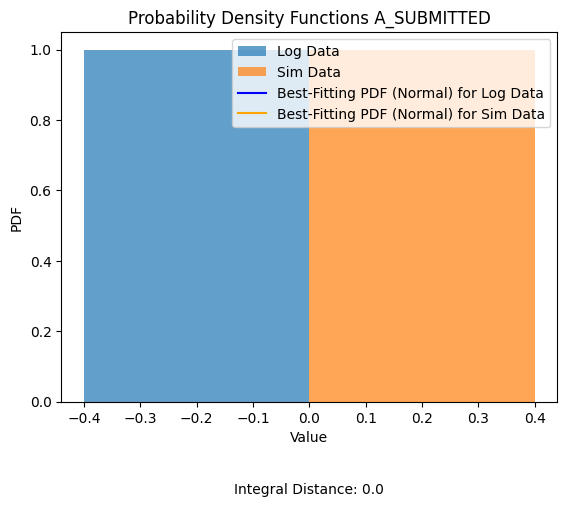

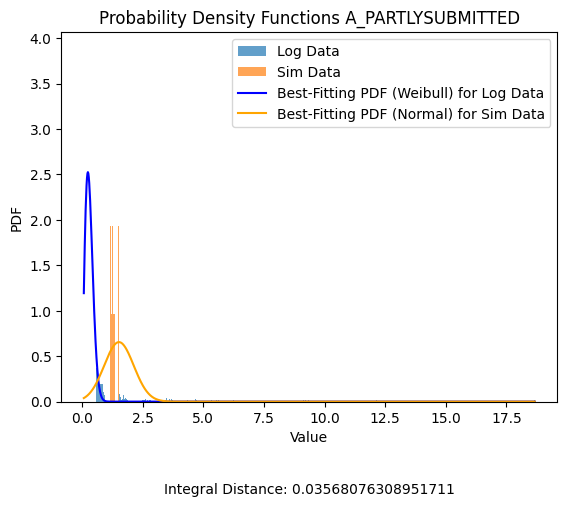

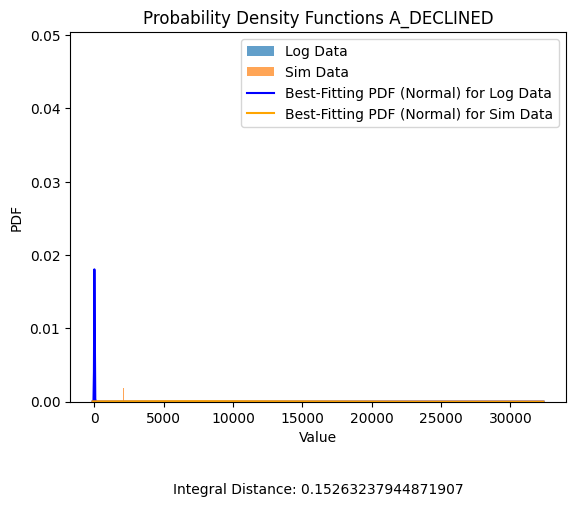

KeyError: 'W_Afhandelen leads'

In [31]:

get_pdf_integral_difference(list(trace_durations.values()), list(sim_trace_durations.values()), title_label='Trace Durations', plot=True)
[get_pdf_integral_difference(activities[k][DURATION], sim_nodes[k][DURATION], title_label=k, plot=True) for k in activities.keys()]
print(get_logs_distance(log, simulated_log))

In [32]:
[print(transition["total_frequency"], trace_count, int(transition["sum"])) for transition in transitions.values()]

"""
Index 0: the activity-resource for which at least one batch has been detected
Index 1: the number of batches for the given activity-resource
Index 2: a list containing all the batches. Each batch is described by:
    # The start timestamp of the batch 
    # The complete timestamp of the batch 
    # The list of events that are executed in the batch
"""
batches = pm4py.discovery.discover_batches(log)

[print(batch) for batch in batches]

5301 5301 2952
3429 5301 130300
1872 5301 34869439
1872 5301 -6916


c:\Users\Yannic\anaconda3\envs\masterarbeit\Lib\site-packages\pm4py\algo\discovery\batches\variants\pandas.py:97: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\Users\Yannic\anaconda3\envs\masterarbeit\Lib\site-packages\pm4py\algo\discovery\batches\variants\pandas.py:99: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(('W_Afhandelen leads', '10931'), 4, {'Concurrent batching': [(1323259566, 1323259926, {(1323259566, 1323259566, '191911'), (1323259926, 1323259926, '191920')}), (1323268459, 1324991251, {(1323857827, 1323857827, '193440'), (1323268459, 1323268459, '191962'), (1323873905, 1323873905, '193539'), (1324991251, 1324991251, '195821')}), (1326096910, 1326097266, {(1326096910, 1326096910, '198855'), (1326097266, 1326097266, '198858')}), (1326098481, 1330088815, {(1326099074, 1326099074, '198930'), (1326102153, 1326102153, '198990'), (1326098481, 1326098481, '198888'), (1326098742, 1326098742, '198921'), (1326106968, 1326106968, '199017'), (1326100673, 1326100673, '198972'), (1326103593, 1326103593, '199005'), (1330088815, 1330088815, '212461'), (1326099193, 1326099193, '198933')})]})
(('A_DECLINED', '10931'), 4, {'Concurrent batching': [(1323259563, 1323259922, {(1323259922, 1323259922, '191920'), (1323259563, 1323259563, '191911')}), (1323268455, 1324991247, {(1323873902, 1323873902, '193539

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [33]:
def seconds_to_dhms_string(seconds):
    days, remainder = divmod(seconds, 86400)
    hours, remainder = divmod(remainder, 3600)
    minutes, seconds = divmod(remainder, 60)

    _days = "" if round(days) == 0 else f"{int(days)}d"
    _hours = "" if round(hours) == 0 else f"{int(hours)}h"
    _minutes = "" if round(minutes) == 0 else f"{int(minutes)}m"
    _seconds = "" if round(seconds) == 0 and (round(minutes) != 0 or round(hours) != 0 or round(days) != 0) else f"{int(seconds)}s"

    return f"{_days} {_hours} {_minutes} {_seconds}"

def select_custom_tickvals(data, num_ticks=5):
    # Calculate the minimum and maximum values in the data
    min_val = min(data)
    max_val = max(data)

    # Calculate the tick interval to achieve even spacing
    tick_interval = (max_val - min_val) / (num_ticks - 1)

    # Calculate custom tick values with even spacing
    custom_tickvals = np.arange(min_val, max_val + tick_interval, tick_interval)

    return custom_tickvals.tolist()

def get_colors(values, global_scale):
  min_value = min(values)
  max_value = max(values)
  
  if global_scale:
    min_value = min(metrics['min'])
    max_value = max(metrics['max'])

  return [get_color(value, min_value, max_value) for value in values]

def get_color(value, min_value, max_value):
    if max_value == min_value:
        normalized_value = 1
    else:
      normalized_value = (value - min_value) / (max_value - min_value)

    hue = 120 - int(120 * normalized_value)  # Hue from 120 (green) to 0 (red)
    saturation = 50  # Reduced saturation for subdued colors
    lightness = 50   # Medium lightness for a pastel effect
    return f'hsl({hue}, {saturation}%, {lightness}%)'

def generate_scatter(node, metrics, color_scale_global):
  if node == None or metrics == None: return {'layout': go.Layout(title=f'Hover over Link for information')} 
  y_axis = metrics[WAITING]
  x_axis = [i for i in range(len(y_axis))]

  y_ticks = select_custom_tickvals(y_axis)

  return {
          'data': [go.Scatter(
              x=x_axis, 
              y=y_axis, 
              mode='markers',
              marker= dict(color = get_colors(y_axis, color_scale_global))
            )],
          'layout': go.Layout(
            yaxis=dict(
              tickvals = y_ticks,
              ticktext = [seconds_to_dhms_string(s) for s in y_ticks]
            )
          ),
        }

def generate_histogramm(node, color_scale_global):
  data = transitions[node][WAITING]
  data = [int(v) for v in data]

  unique_values, value_counts = np.unique(data, return_counts=True)
  x_ticks = select_custom_tickvals(data, len(unique_values))

  trace = go.Histogram(
    x=data, 
    nbinsx=len(unique_values), 
    opacity=0.7, 
    marker=dict(color = get_colors(unique_values, color_scale_global)),
  )

  layout = go.Layout(
    xaxis=dict(
       title='Waiting Time',
       tickvals = x_ticks,
       ticktext = [seconds_to_dhms_string(s) for s in x_ticks]
    ),
    yaxis=dict(title='Frequency'),
    bargap=0.05
  )
  return go.Figure(data=[trace], layout=layout)


def generate_sankey(metric, color_scale_global=False):

  source, target = zip(*transitions.keys())
  node_labels = list(set(source + target))
  source_nodes = [node_labels.index(transition[0]) for transition in transitions.keys()]
  target_nodes = [node_labels.index(transition[1]) for transition in transitions.keys()]

  return go.Figure(go.Sankey(
    arrangement = "snap",
    valuesuffix = "s",

    node = dict(
      pad = 50,
      thickness = 10,
      line = dict(width = 0),
      label = node_labels,
    ),
    link = dict(
      source = source_nodes,
      target = target_nodes,
      value = metrics[metric],
      color = get_colors(metrics[metric], color_scale_global),
      customdata = [seconds_to_dhms_string(v) for v in metrics[metric]],
      hovertemplate =  metric + ": %{customdata}"
  )))

def get_sorce_target_from_hover_data(data):
  source, target = zip(*transitions.keys())
  if data is None: return
  if 'group' in data['points'][0]: return
  idx = data['points'][0]['index']
  return (source[idx], target[idx])
  


In [34]:
app = dash.Dash(__name__)

sankey_div = html.Div([dcc.Graph(id='sankey-plot')], style={'width': '66%', 'padding': '20px'})

# Filter div with 33% width
filter_div = html.Div(
    children=[
        dcc.Dropdown(
            id='metric-dropdown',
            options=[{'label': key, 'value': key} for key in metrics.keys()],
            value='median',
        ),
        dcc.Checklist(
            id='global-color-scale',
            options=[{'label': 'Use global color scale', 'value': True}],
            value=[]
        ),
        html.Div([html.Plaintext(id='hover-details', children="Hover over a Sankey element to see details:")])
    ],
    style={'width': '33%', 'padding': '20px'}
)

# Details div with children having even spacing horizontally
details_div = html.Div([
    html.Div([dcc.Graph(id='scatter-plot', figure={})], style={'flex': 1}),
    html.Div([dcc.Graph(id='hist-plot', figure={})], style={'flex': 1}),
], style={'display': 'flex', 'flex-wrap': 'wrap'})

# Overall layout
app.layout = html.Div(
    style={'backgroundColor': 'white', 'zoom': '100%'},
    children=[
        html.Div(style={'display': 'flex'}, children=[sankey_div, filter_div]),  # First row
        details_div,  # Second row
    ]
)

@callback(
    Output('hover-details', 'children'),
    Output('scatter-plot', 'figure'),
    Output('hist-plot', 'figure'),
    Input('sankey-plot', 'hoverData'),
    Input('global-color-scale', 'value')
)
def update_details(hover_data, color_scale_global):
    node = get_sorce_target_from_hover_data(hover_data)

    if node is None: return "",{},{}

    metrics = [f"{k} : {seconds_to_dhms_string(v)}" for k,v in transitions[node].items() if k != "waiting_times"]

    return "\n".join(metrics), generate_scatter(node, transitions[node], color_scale_global), generate_histogramm(node, color_scale_global)

# Filter Sankey
@callback(
    Output('sankey-plot', 'figure'),
    Input('metric-dropdown', 'value'),
    Input('global-color-scale', 'value')
)
def update_sankey(metric, color_scale_global):
    return generate_sankey(metric, color_scale_global)
    

# Run the app in Jupyter notebook inline mode
if __name__ == '__main__':
    app.run_server(mode="inline")